<img src="https://github.com/rjpost20/Anomalous-Bank-Transactions-Detection-Project/blob/main/data/AdobeStock_319163865.jpeg?raw=true">
Image by <a href="https://stock.adobe.com/contributor/200768506/andsus?load_type=author&prev_url=detail" >AndSus</a> on Adobe Stock

# Phase 5 Project: *Detecting Anomalous Financial Transactions*

## Notebook 1: Intro, EDA and Preprocessing

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 25th, 2022<br>
Instructor: Joseph Mata

## Goal: 

*This is a project for learning purposes. The *** is not involved with this project in any way.*

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Imports, Reading in Data, and Exploratory Data Analysis

### Google colab compatibility downloads

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz 
!tar xf spark-3.3.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
!pip install pyspark==3.3.0
!pip install -q findspark
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,533 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://a

In [2]:
# Connect to Google drive
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries, packages and modules

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from itertools import chain

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, TimestampType
# from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from IPython.display import HTML, display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
helper_functions = files.upload()
from helper_functions import spark_resample

In [4]:
# Check colab GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
# Set text to wrap in Google colab notebook
def set_css():
    display(HTML('''
    <style>
      pre {
          white-space: pre-wrap;
      }
    </style>
    '''))
get_ipython().events.register('pre_run_cell', set_css)

In [7]:
# Initialize Spark Session - Jupyter (local)
# spark = SparkSession.builder.master('local[*]').getOrCreate()

# Initialize Spark Session - Colab
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark.version

'3.3.0'

### Description of Features

**Dataset 1 – Transactions:**

`MessageId` - Globally unique identifier within this dataset for individual transactions<br>
`UETR` - The Unique End-to-end Transaction Reference—a 36-character string enabling traceability of all individual transactions associated with a single end-to-end transaction<br>
`TransactionReference` - Unique identifier for an individual transaction<br>
`Timestamp` - Time at which the individual transaction was initiated<br>
`Sender` - Institution (bank) initiating/sending the individual transaction<br>
`Receiver` - Institution (bank) receiving the individual transaction<br>
`OrderingAccount` - Account identifier for the originating ordering entity (individual or organization) for end-to-end transaction<br>
`OrderingName` - Name for the originating ordering entity<br>
`OrderingStreet` - Street address for the originating ordering entity<br>
`OrderingCountryCityZip` - Remaining address details for the originating ordering entity<br>
`BeneficiaryAccount` - Account identifier for the final beneficiary entity (individual or organization) for end-to-end transaction<br>
`BeneficiaryName` - Name for the final beneficiary entity<br>
`BeneficiaryStreet` - Street address for the final beneficiary entity<br>
`BeneficiaryCountryCityZip` - Remaining address details for the final beneficiary entity<br>
`SettlementDate` - Date the individual transaction was settled<br>
`SettlementCurrency` - Currency used for transaction<br>
`SettlementAmount` - Value of the transaction net of fees/transfer charges/forex<br>
`InstructedCurrency` - Currency of the individual transaction as instructed to be paid by the Sender<br>
`InstructedAmount` - Value of the individual transaction as instructed to be paid by the Sender<br>
`Label` - Boolean indicator of whether the transaction is anomalous or not. This is the target variable for the prediction task.<br>
<br>
**Dataset 2 – Banks:**

`Bank` - Identifier for the bank<br>
`Account` - Identifier for the account<br>
`Name` - Name of the account<br>
`Street` - Street address associated with the account<br>
`CountryCityZip` - Remaining address details associated with the account<br>
`Flags` - Enumerated data type indicating potential issues or special features that have been associated with an account. Flag definitions are below:<br>
00 - No flags<br>
01 - Account closed<br>
03 - Account recently opened<br>
04 - Name mismatch<br>
05 - Account under monitoring<br>
06 - Account suspended<br>
07 - Account frozen<br>
08 - Non-transaction account<br>
09 - Beneficiary deceased<br>
10 - Invalid company ID<br>
11 - Invalid individual ID<br>
<br>
Additional information from data providers:<br>
"Because each end-to-end transaction is defined by one originating orderer and one final beneficiary, the `OrderingAccount` and `BeneficiaryAccount` in a given row may not necessarily belong to the bank in that row's `Sender` and the bank in that row's `Receiver`, respectively. The correct way to associate an `OrderingAccount` to the correct bank is to identify the `Sender` bank in the originating (first) individual transaction in that end-to-end transaction, and the correct way to associate a `BeneficiaryAccount` to the correct bank is to identify the `Receiver` bank in the final (last) individual transaction in that end-to-end transaction."

### Read in Data

In [8]:
# Read in transactions training and testing data csv files to Spark DataFrames - Jupyter (local)
# train_df = spark.read.csv('data/transaction_train_dataset.csv', header=True, inferSchema=True)
# test_df = spark.read.csv('data/transaction_test_dataset.csv', header=True, inferSchema=True)

# Read in transactions training and testing data csv files to Spark DataFrames - Colab
train_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_train_dataset.csv', header=True, inferSchema=True)
test_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/transaction_test_dataset.csv', header=True, inferSchema=True)

# Read in banks data csv file to a Spark DataFrame
banks_df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/bank_dataset.csv', header=True, inferSchema=True)

# Persist in memory
# train_df = train_df.cache()
# test_df = test_df.cache()
# banks_df = banks_df.cache()

<br>

## Preliminary EDA

In [ ]:
# Print shape of dataframes
print(f"train_df:  {train_df.count():,} Rows, {len(train_df.columns)} Columns")
print(f"test_df:  {test_df.count():,} Rows, {len(test_df.columns)} Columns")
print(f"banks_df:  {banks_df.count():,} Rows, {len(banks_df.columns)} Columns")

In [33]:
# Print schema of train_df dataframe
train_df.printSchema()

root
 |-- MessageId: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- UETR: string (nullable = true)
 |-- Sender: string (nullable = true)
 |-- Receiver: string (nullable = true)
 |-- TransactionReference: string (nullable = true)
 |-- OrderingAccount: string (nullable = true)
 |-- OrderingName: string (nullable = true)
 |-- OrderingStreet: string (nullable = true)
 |-- OrderingCountryCityZip: string (nullable = true)
 |-- BeneficiaryAccount: string (nullable = true)
 |-- BeneficiaryName: string (nullable = true)
 |-- BeneficiaryStreet: string (nullable = true)
 |-- BeneficiaryCountryCityZip: string (nullable = true)
 |-- SettlementDate: integer (nullable = true)
 |-- SettlementCurrency: string (nullable = true)
 |-- SettlementAmount: double (nullable = true)
 |-- InstructedCurrency: string (nullable = true)
 |-- InstructedAmount: double (nullable = true)
 |-- Label: integer (nullable = true)



In [34]:
# Print schema of banks_df dataframe
banks_df.printSchema()

root
 |-- Bank: string (nullable = true)
 |-- Account: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- CountryCityZip: string (nullable = true)
 |-- Flags: integer (nullable = true)



In [38]:
# Display first row of train_df
train_df.show(n=1, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------
 MessageId                 | TRA7CGN3FF                           
 Timestamp                 | 2022-01-01 00:00:00                  
 UETR                      | f474fdb3-4675-4fff-ab7e-3469f82bd6a7 
 Sender                    | DPSUFRPP                             
 Receiver                  | ABVVUS6S                             
 TransactionReference      | PETX22-FXIDA-7054                    
 OrderingAccount           | FR90714755422956984353               
 OrderingName              | PHACELIA HETEROPHYLLA                
 OrderingStreet            | 3| RUE HAMON                         
 OrderingCountryCityZip    | FR/42859 SAINTE AURÉLIE              
 BeneficiaryAccount        | 611024064274704358                   
 BeneficiaryName           | PAPAVER CALIFORNICUM                 
 BeneficiaryStreet         | 2584 CHARLES PLACE                   
 BeneficiaryCountryCityZip | US/ROJASLAND| DC 58442           

In [39]:
# Display first 5 rows of banks dataframe
banks_df.show(n=5, truncate=False)

+--------+------------------+-----------------------+-------------------------+--------------------------+-----+
|Bank    |Account           |Name                   |Street                   |CountryCityZip            |Flags|
+--------+------------------+-----------------------+-------------------------+--------------------------+-----+
|ABVVUS6S|611024064274690946|OXYTROPIS PODOCARPA    |784 YANG PASSAGE         |US/NEW SHANNON, IA 49432  |0    |
|ABVVUS6S|611024064274690947|VIOLA ◊ESCULENTA       |786 CINDY HARBOR         |US/APO AP 02202           |0    |
|ABVVUS6S|611024064274690948|CROSSOSOMA CALIFORNICUM|235 JAMES VIEWS SUITE 206|US/ORRVILLE, LA 49084     |0    |
|ABVVUS6S|611024064274690949|HYDROCOTYLE PROLIFERA  |270 THERESA MILL         |US/WEST JAYSHIRE, WA 67409|0    |
|ABVVUS6S|611024064274690950|CHAMAEMELUM FUSCATUM   |20734 ISAIAH BURG        |US/KINGVIEW, CO 71032     |0    |
+--------+------------------+-----------------------+-------------------------+-----------------

In [ ]:
# Print number of null/missing values in each column of train_df
train_df_null = train_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in train_df.columns if c != 'Timestamp'])

print('Number of null/missing values per column:\n')
train_df_null.show(vertical=True, truncate=False)

In [ ]:
# # Print number of null/missing values in each column of banks_df
banks_df_null = banks_df.select([F.count(F.when(F.col(c).isNull() | F.isnan(c), c))\
                                 .alias(c) for c in banks_df.columns])

print('Number of null/missing values per column:\n')
banks_df_null.show(vertical=True, truncate=False)

In [ ]:
# Print number of unique values in each column of train_df; sample 1% of df for efficiency
train_df_unique = train_df.sample(False, 0.01).agg(*(F.countDistinct(F.col(c)) for c in train_df.columns))

print(f"Number of unique values per column (in sample of 1% of dataframe):\n")
train_df_unique.show(vertical=True, truncate=False)

In [ ]:
# Print number of unique values in each column in banks_df; sample 10% of df for efficiency
banks_df_unique = banks_df.sample(False, 0.1).agg(*(F.countDistinct(F.col(c)) for c in banks_df.columns))

print(f"Number of unique values per column (in sample of 10% of dataframe):\n")
banks_df_unique.show(vertical=True, truncate=False)

In [ ]:
# Display Pandas style summary statistics table of numeric columns in train_df
num_cols = [item[0] for item in train_df.dtypes if item[1] == 'int' or item[1] == 'double']

train_df.select(num_cols).summary().show(truncate=False)

In [ ]:
# Display value counts for 'Label' column (classification target) in train_df
class_counts = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())

class_counts.show(truncate=10)

**Remarks:**
- It looks like this is an extremely imbalanced dataset - only about 0.1% of the data is in the positive class. We will need to address this class imbalance as part of the modeling process.

<br>

## Detailed EDA

In [9]:
# Sample 2% of train_df for visualizations (approximately 94k observations)
viz_df = train_df.sample(withReplacement=False, fraction=0.02, seed=42).toPandas()

### Visualize target class distributions of sender and receiver banks used in transactions

In [10]:
# Display unique senders in training dataset
print(f"train_df, {train_df.select('Sender').distinct().count()} unique senders:")
train_df.select('Sender').distinct().show(5)

train_df, 16 unique senders:
+--------+
|  Sender|
+--------+
|ZOUOGB22|
|MRQHUS44|
|BRRGPTPL|
|GDYCCHZZ|
|HNYPITMM|
+--------+
only showing top 5 rows



In [11]:
# Display unique senders in training dataset where transaction is anomalous
unique_anom_senders_count = train_df.filter(train_df.Label == 1)\
                                    .select('Sender').distinct().count()

print(f"train_df, {unique_anom_senders_count} unique senders among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Sender').distinct().show(5)

train_df, 5 unique senders among anomalous transactions:
+--------+
|  Sender|
+--------+
|ZOUOGB22|
|WVOLDEMM|
|ABVVUS6S|
|DPSUFRPP|
|UNUSAL22|
+--------+



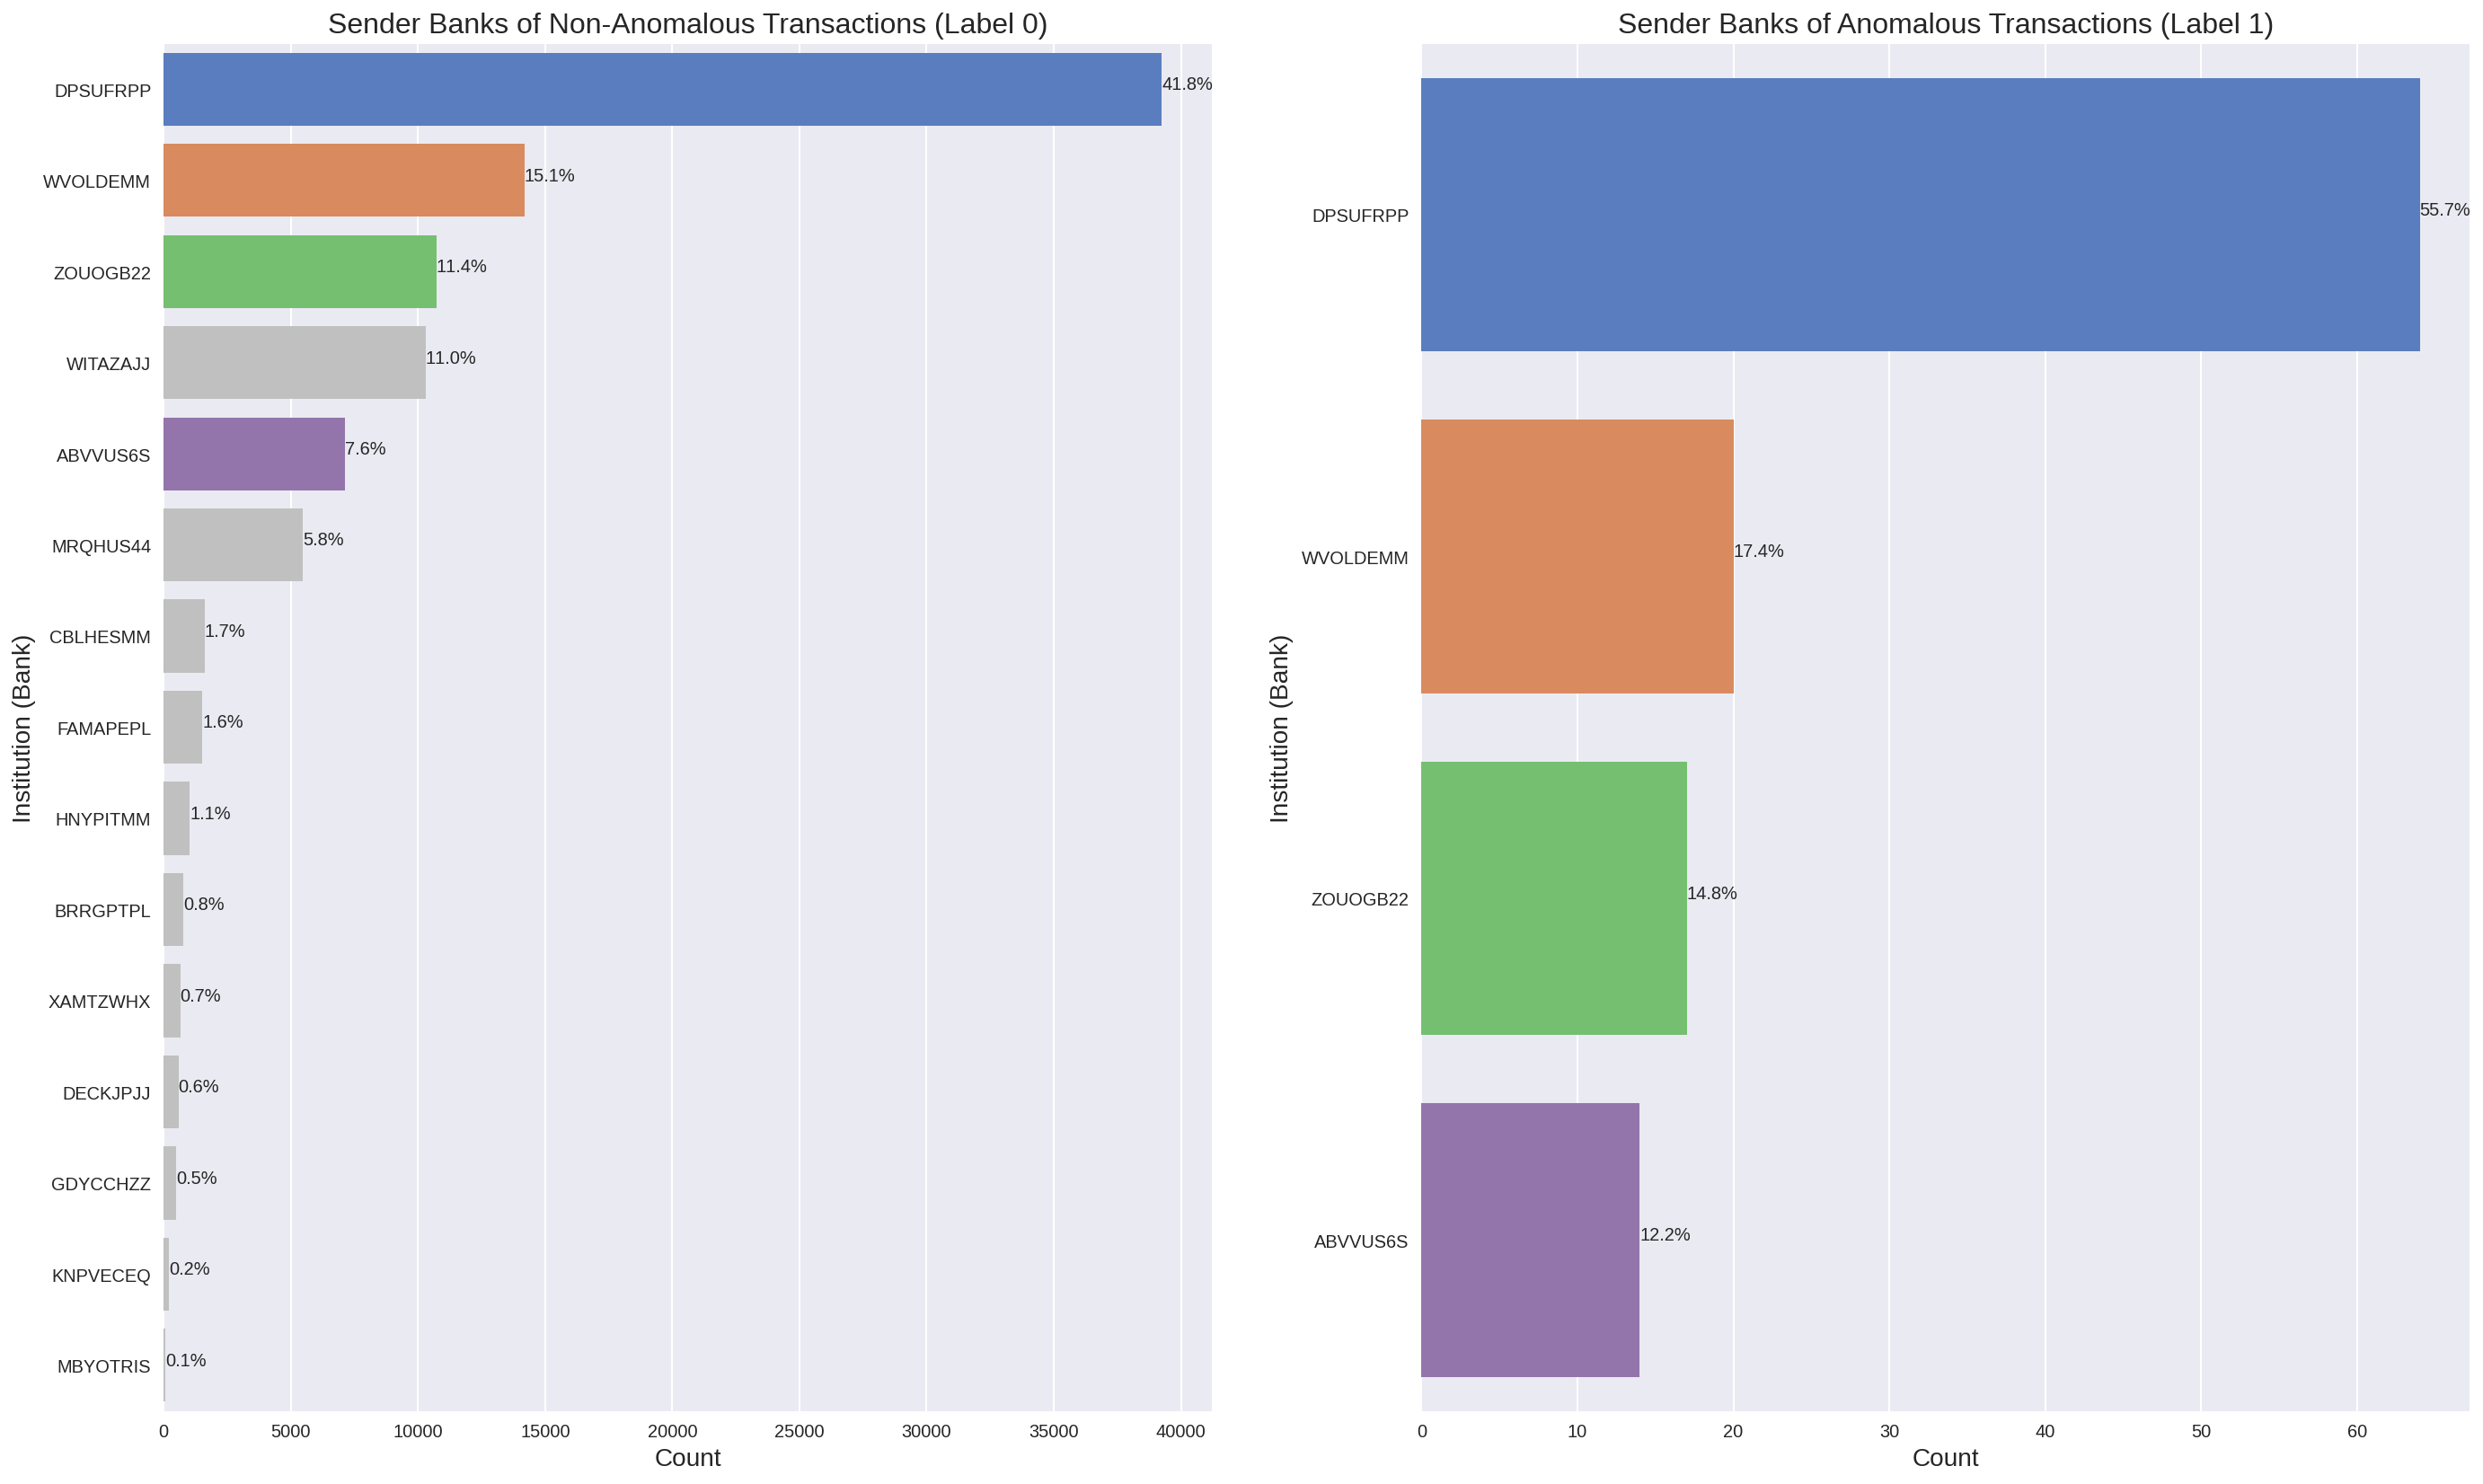

In [26]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['Sender'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Sender'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Sender'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Sender'].value_counts().index) # Order descending

# Plot countplot of anomalous transactions
sns.countplot(y='Sender', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Sender'].value_counts().index) # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Sender Banks of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Institution (Bank)', fontsize=14)
ax2.set_title('Sender Banks of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Institution (Bank)', fontsize=14);

In [18]:
# Display unique receivers in training dataset
print(f"train_df, {train_df.select('Receiver').distinct().count()} unique receivers:")
train_df.select('Receiver').distinct().show(5)

train_df, 27 unique receivers:
+--------+
|Receiver|
+--------+
|WOEBDOSD|
|ZOUOGB22|
|BRRGPTPL|
|IHJTNL2A|
|GDYCCHZZ|
+--------+
only showing top 5 rows



In [19]:
# Display unique receivers in training dataset where transaction is anomalous
unique_anom_receivers_count = train_df.filter(train_df.Label == 1)\
                                      .select('Receiver').distinct().count()

print(f"train_df, {unique_anom_receivers_count} unique receivers among anomalous transactions:")
train_df.filter(train_df.Label == 1).select('Receiver').distinct().show(5)

train_df, 27 unique receivers among anomalous transactions:
+--------+
|Receiver|
+--------+
|WOEBDOSD|
|ZOUOGB22|
|BRRGPTPL|
|IHJTNL2A|
|GDYCCHZZ|
+--------+
only showing top 5 rows



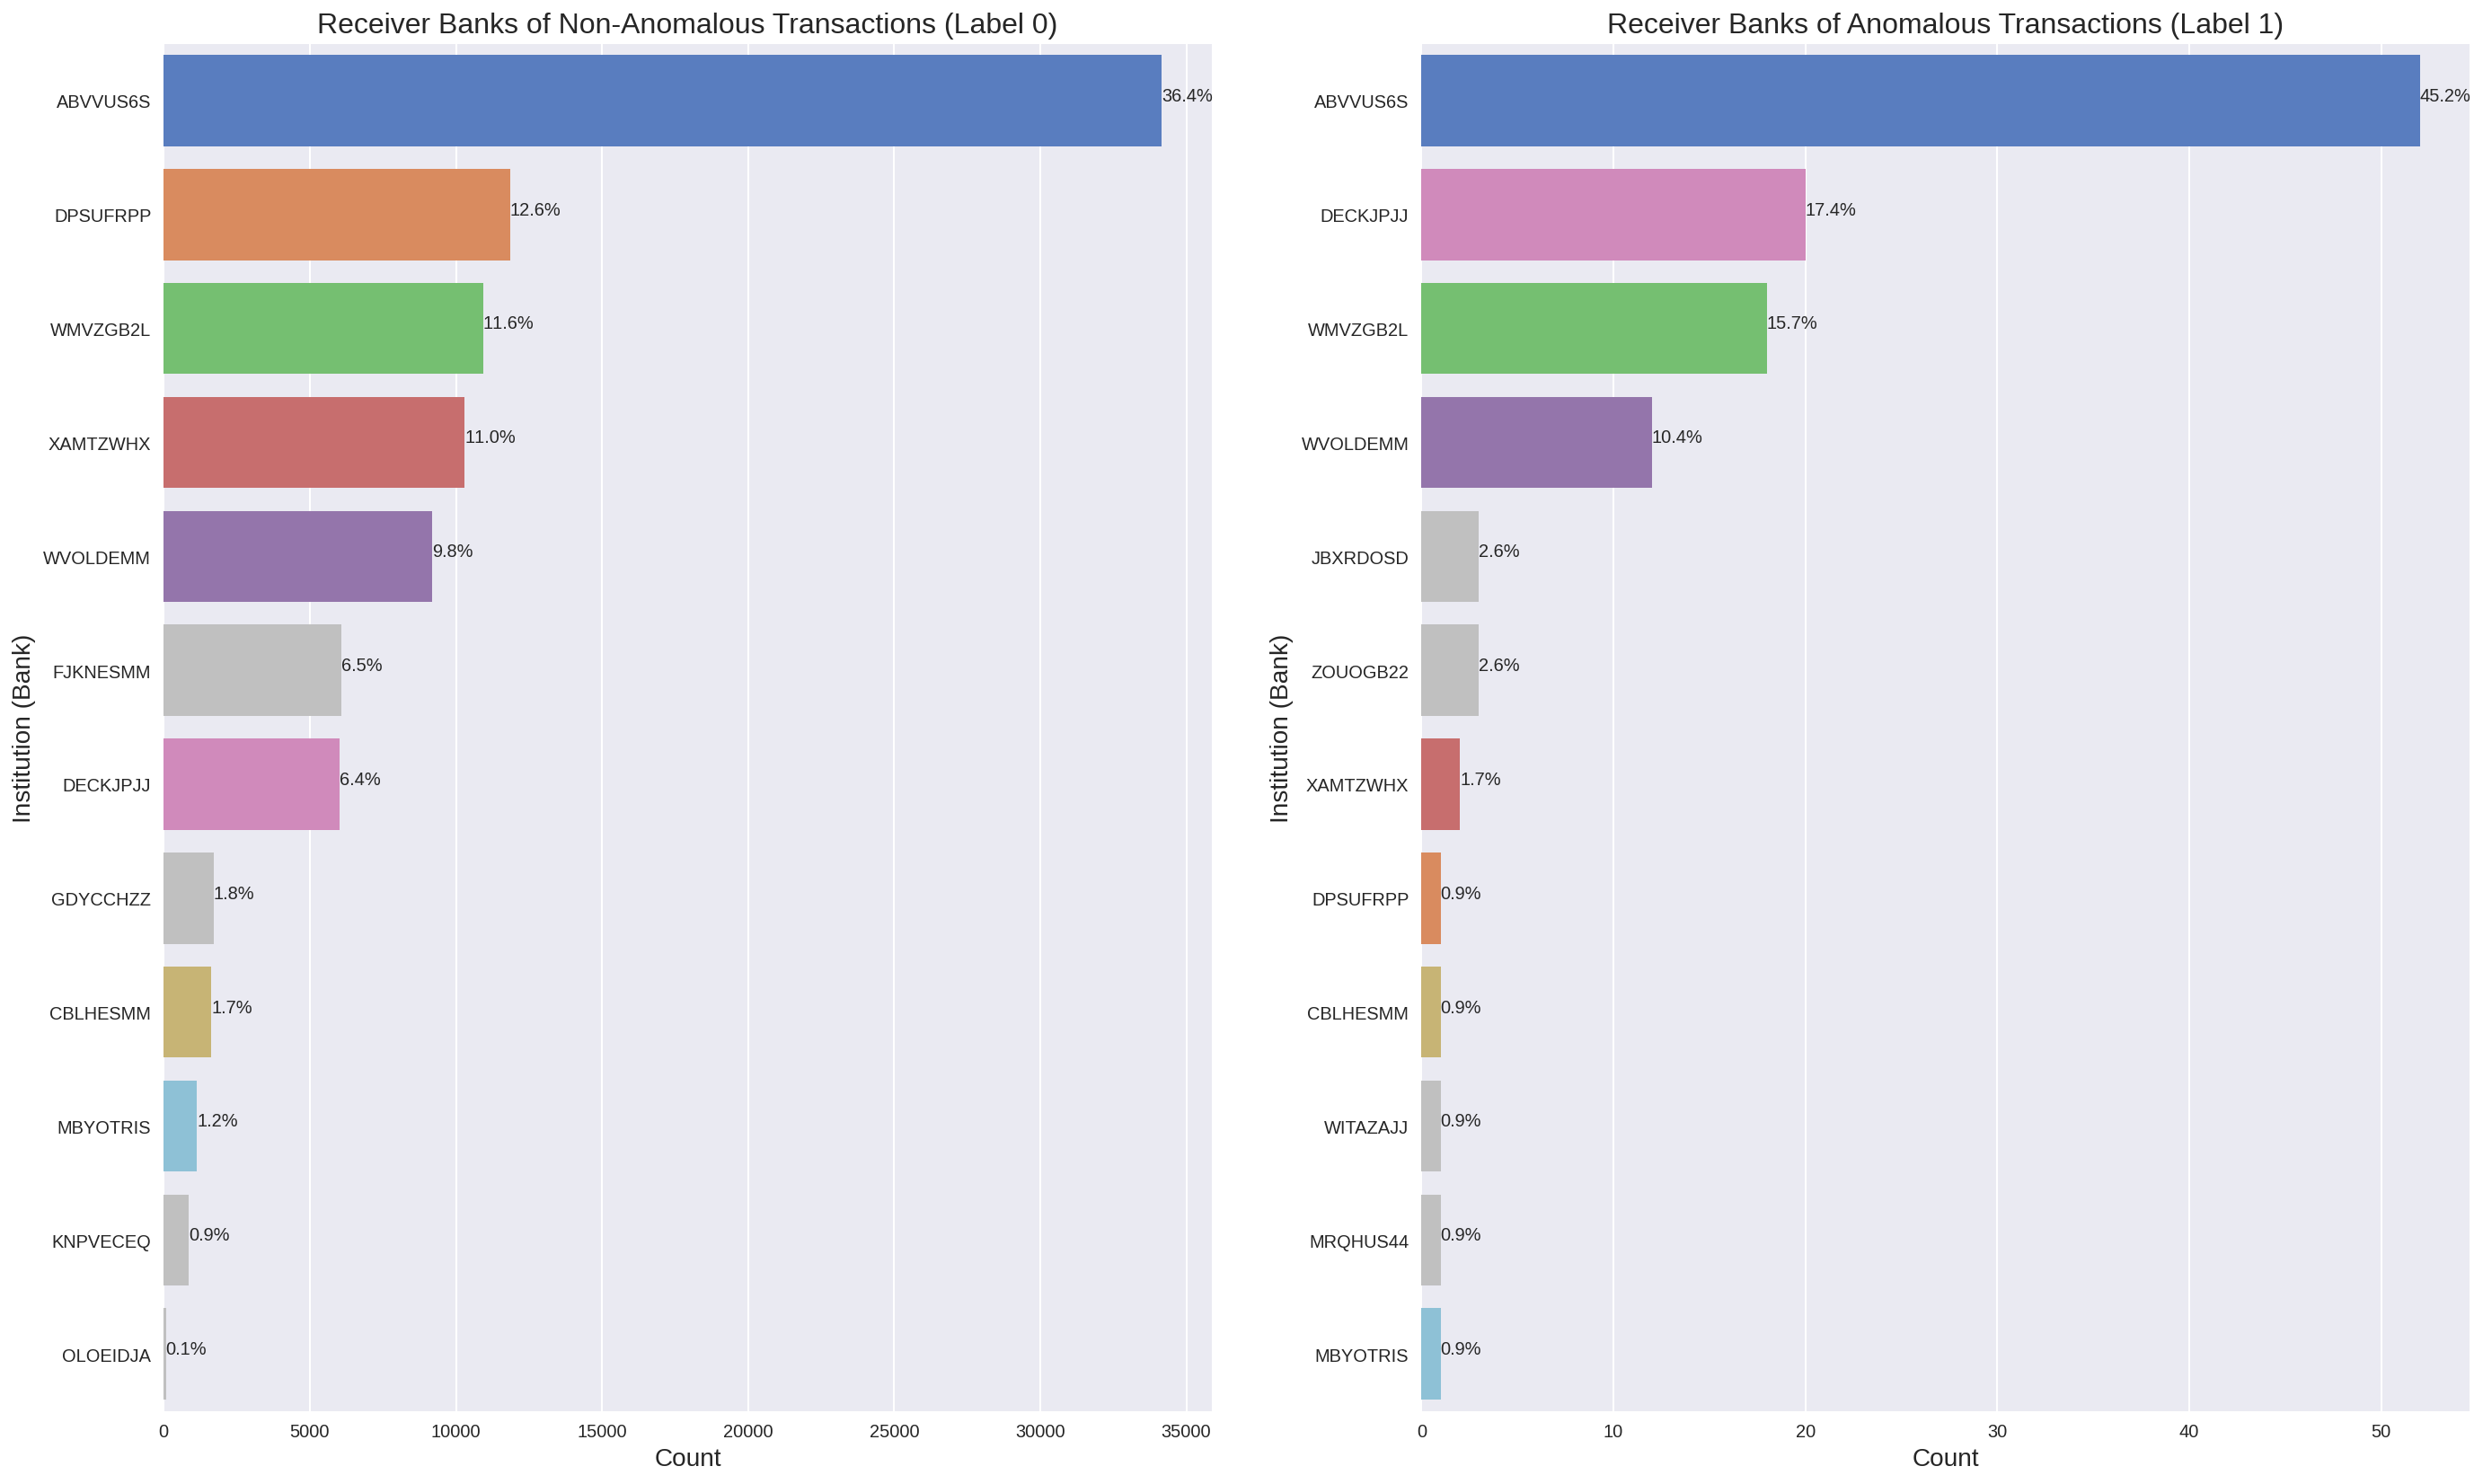

In [25]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(23, 14))

# Set consistent color palette where y-axis values in both axes, otherwise silver
palette = sns.color_palette('muted', as_cmap=True)*2
palette_map = {}
for val, color in zip(viz_df['Receiver'].value_counts().index, palette):
    if val in viz_df[viz_df.Label == 0]['Receiver'].value_counts().index \
    and val in viz_df[viz_df.Label == 1]['Receiver'].value_counts().index:
        palette_map[val] = color
    else:
        palette_map[val]= 'silver'

# Plot countplot of non-anomalous transactions
ax1_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 0], ax=ax1, palette=palette_map, 
              order=viz_df[viz_df.Label == 0]['Receiver'].value_counts().index)  # Order descending

# Update palette_map with values not found above
for val, color in zip(viz_df[viz_df.Label == 1]['Receiver'].value_counts().index, palette):
    if val not in palette_map:
        palette_map[val] = 'silver'  # Assign values not found above to silver


# Plot countplot of anomalous transactions
ax2_plot = sns.countplot(y='Receiver', data=viz_df[viz_df.Label == 1], ax=ax2, palette=palette_map, 
              order=viz_df[viz_df.Label == 1]['Receiver'].value_counts().index)  # Order descending

# Print percentages to the right of bars (ax1)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 0].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax1.annotate(percentage, (x, y))

# Print percentages to the right of bars (ax2)
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/viz_df[viz_df.Label == 1].shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height()/2
    ax2.annotate(percentage, (x, y))

ax1.set_title('Receiver Banks of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Count', fontsize=14)
ax1.set_ylabel('Institution (Bank)', fontsize=14)
ax2.set_title('Receiver Banks of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Count', fontsize=14)
ax2.set_ylabel('Institution (Bank)', fontsize=14);

**Remarks:**
- It looks like the choice of sender bank is very informative in terms of determining whether a transaction is anomalous or not, while the choice of receiver bank is not nearly as valuable.
- Only 4 out of 16 sender banks tend to be utilized in anomalous transactions, while nearly all are utilized in non-anomalous transactions.
- Looking at receiver banks, 12 out of 16 tend to be utilized for both anomalous and non-anomalous transactions, and in roughly equal distributions.
- There is no need to choose between sender and receiver banks when selecting our features; we can engineer features in sender-receiver bank combinations.

## Visualize target class distributions of instructed and settlement currencies used in transactions

In [27]:
# Display unique instructed currencies used in transactions
print(f"train_df, {train_df.select('InstructedCurrency').distinct().count()} unique instructed currencies:")
train_df.select('InstructedCurrency').distinct().show()

train_df, 8 unique instructed currencies:
+------------------+
|InstructedCurrency|
+------------------+
|               NZD|
|               GBP|
|               CAD|
|               EUR|
|               AUD|
|               JPY|
|               INR|
|               USD|
+------------------+



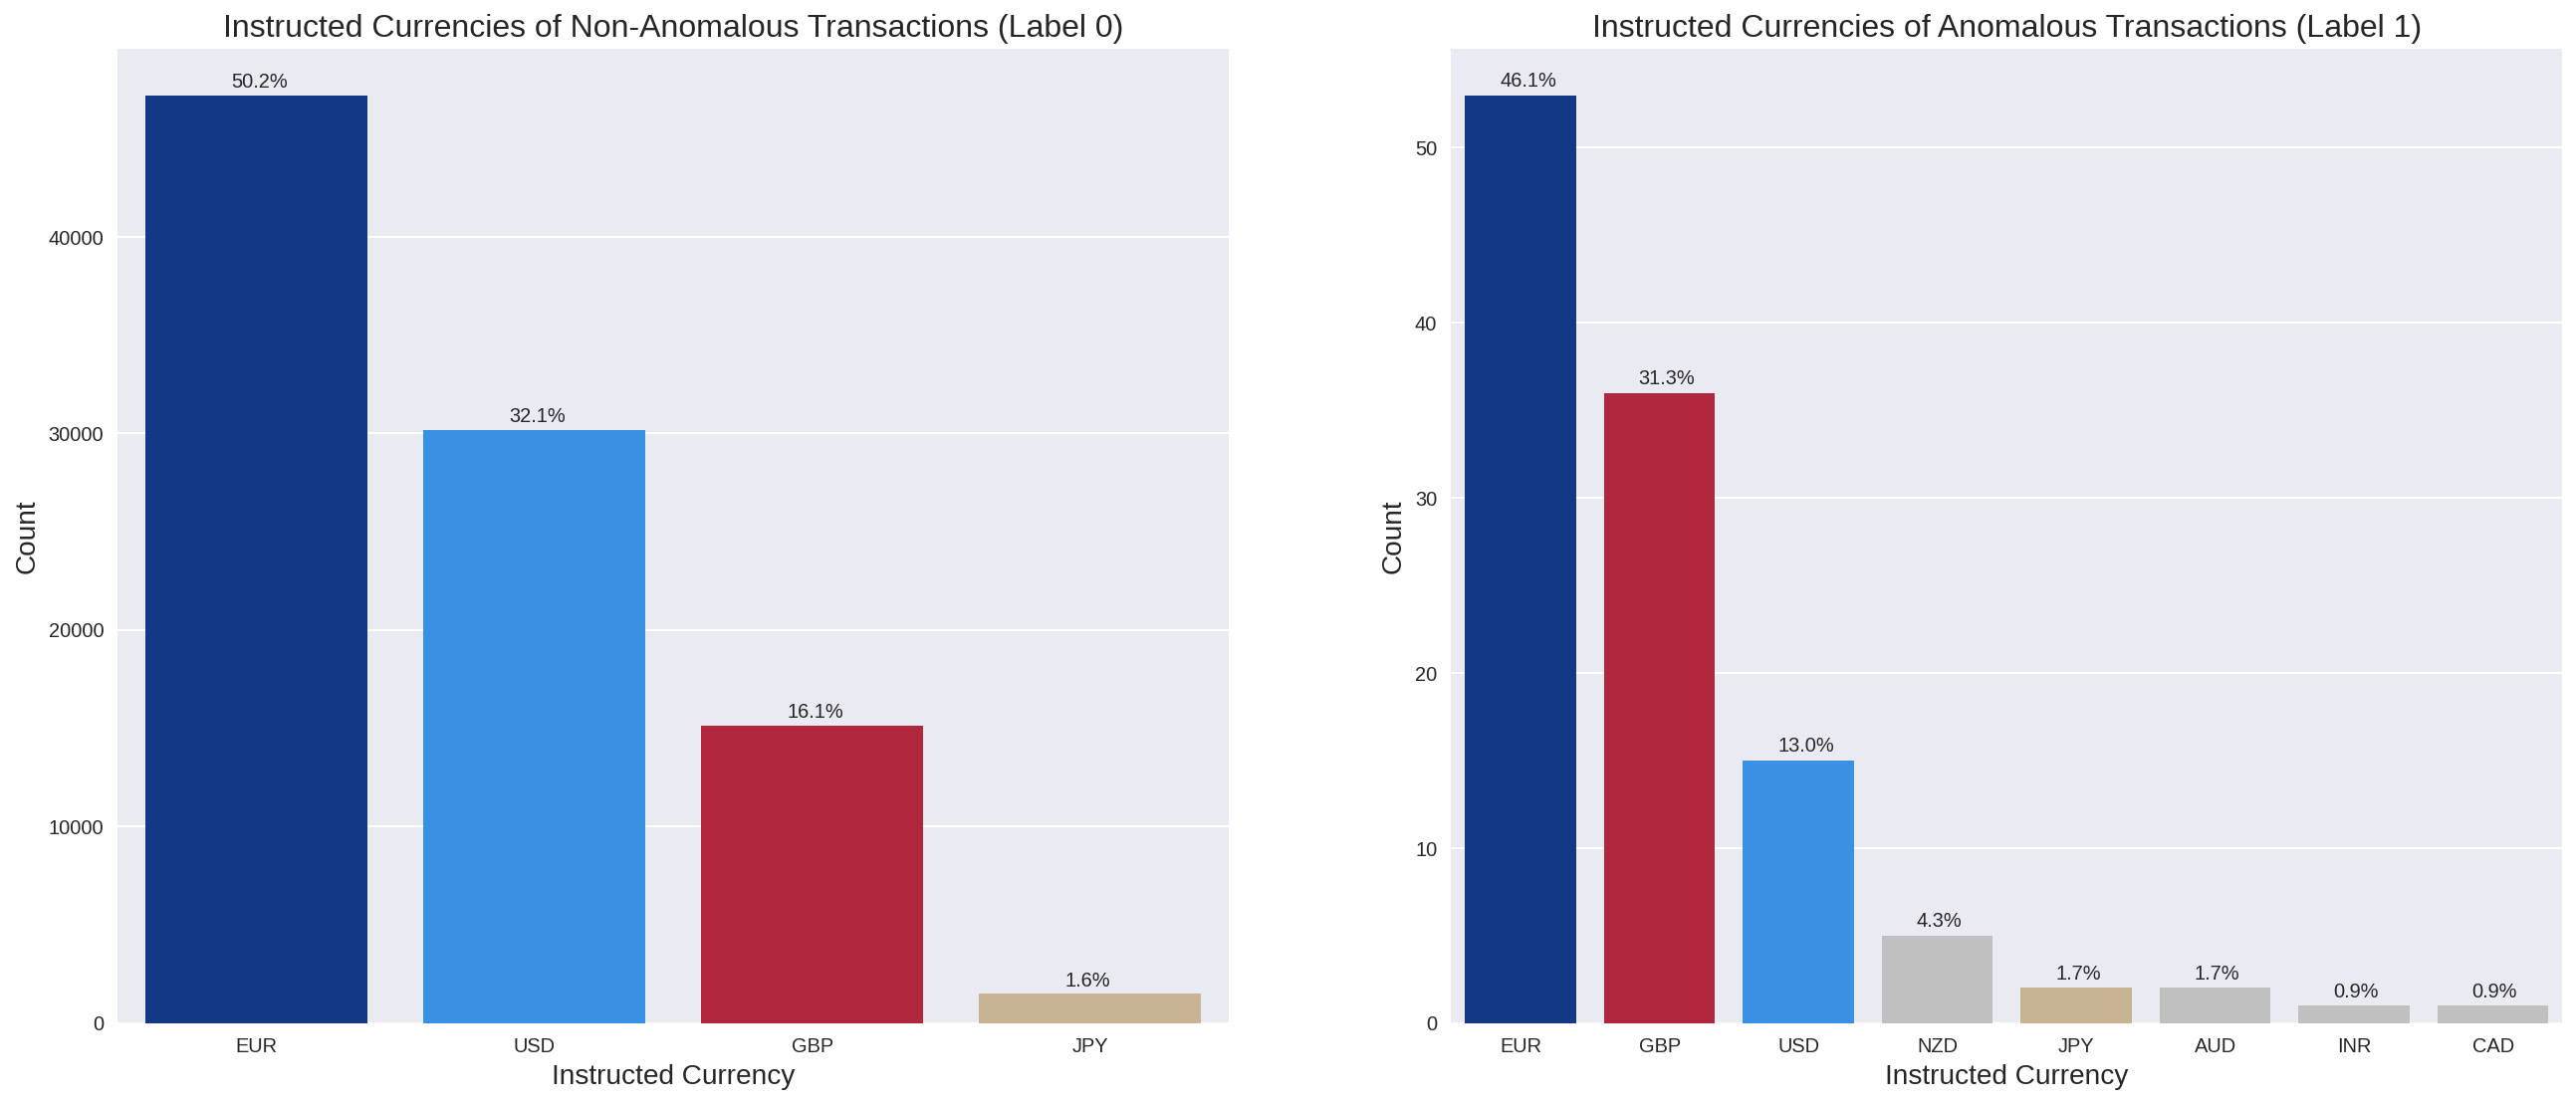

In [29]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette where x-axis values in both axes, otherwise silver
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}
for val in viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index:
    if val not in viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index:
        palette_map[val] = 'silver'

# Plot countplot of non-anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='InstructedCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['InstructedCurrency'].value_counts().index,  # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.31
    txt_y = p.get_height()+400
    ax1.text(txt_x, txt_y, txt)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.25
    txt_y = p.get_height()+0.5
    ax2.text(txt_x, txt_y, txt)

ax1.set_title('Instructed Currencies of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Instructed Currency', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax2.set_title('Instructed Currencies of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Instructed Currency', fontsize=14)
ax2.set_ylabel('Count', fontsize=14);

In [30]:
# Display unique settlement currencies used in transactions
print(f"train_df, {train_df.select('SettlementCurrency').distinct().count()} unique settlement currencies:")
train_df.select('SettlementCurrency').distinct().show()

train_df, 4 unique settlement currencies:
+------------------+
|SettlementCurrency|
+------------------+
|               GBP|
|               EUR|
|               JPY|
|               USD|
+------------------+



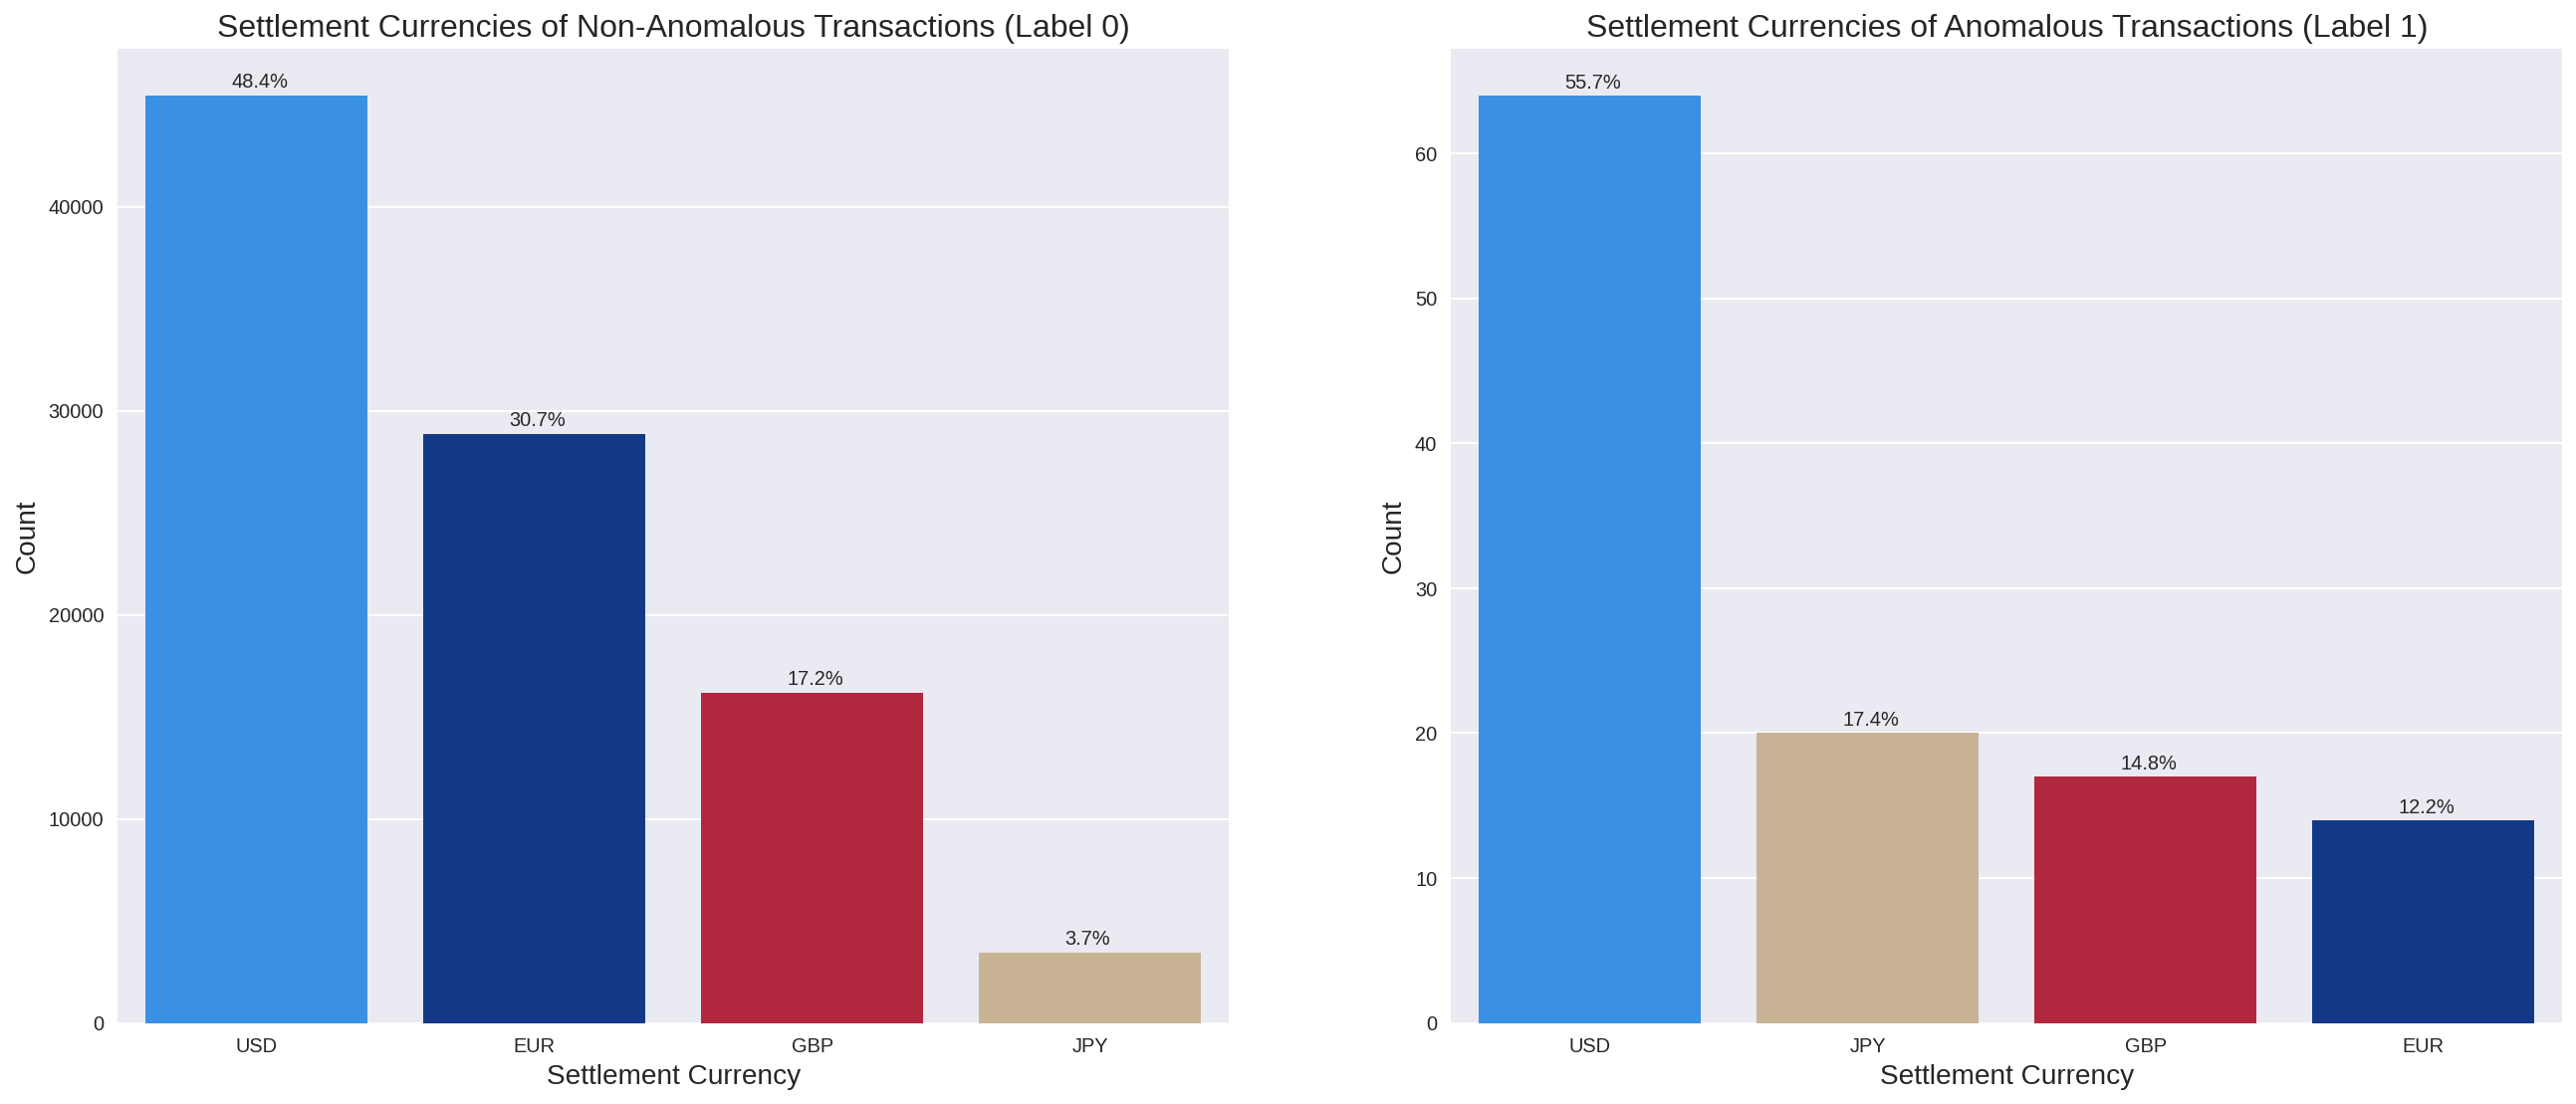

In [32]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Set consistent color palette
palette_map = {'USD': 'dodgerblue', 'EUR': '#003399', 'GBP':'#C8102E', 'JPY': 'tan'}

# Plot countplot of non-anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 0], ax=ax1, 
              order=viz_df[viz_df.Label == 0]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Plot countplot of anomalous transactions
sns.countplot(x='SettlementCurrency', data=viz_df[viz_df.Label == 1], ax=ax2, 
              order=viz_df[viz_df.Label == 1]['SettlementCurrency'].value_counts().index, # Order descending
              palette=palette_map)

# Print percentages on top of bars (ax1)
for p in ax1.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 0].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.31
    txt_y = p.get_height()+400
    ax1.text(txt_x, txt_y, txt)

# Print percentages on top of bars (ax2)
for p in ax2.patches:
    txt = str(round(p.get_height() / viz_df[viz_df.Label == 1].shape[0]*100, 1)) + '%'
    txt_x = p.get_x()+0.31
    txt_y = p.get_height()+0.5
    ax2.text(txt_x, txt_y, txt)

ax1.set_title('Settlement Currencies of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Settlement Currency', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax2.set_title('Settlement Currencies of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Settlement Currency', fontsize=14)
ax2.set_ylabel('Count', fontsize=14);

**Remarks:**
- Instructed currencies seems to be more informative in terms of being correlated with whether or not a transaction is anomalous.
- Among instructed currencies, we see the opposite trend as we saw with chosen banks; anomalous transactions tend to use a broader selection of instructed currencies, rather than a more narrow selection as we saw with chosen sender banks.
- Among settlement currencies, we see the same four currencies being utilized among both target classes, but in slightly different frequencies.
- We will keep the instructed currencies (and one hot encode them) as a feature in the final dataset and drop the settlement currencies.

## Visualize target class distributions of instructed transaction amounts

We'll only plot instructed transaction amounts, since settlement amounts are essentially equivalent to instructed amounts, with the difference being deductions for fees and transfer/forex charges

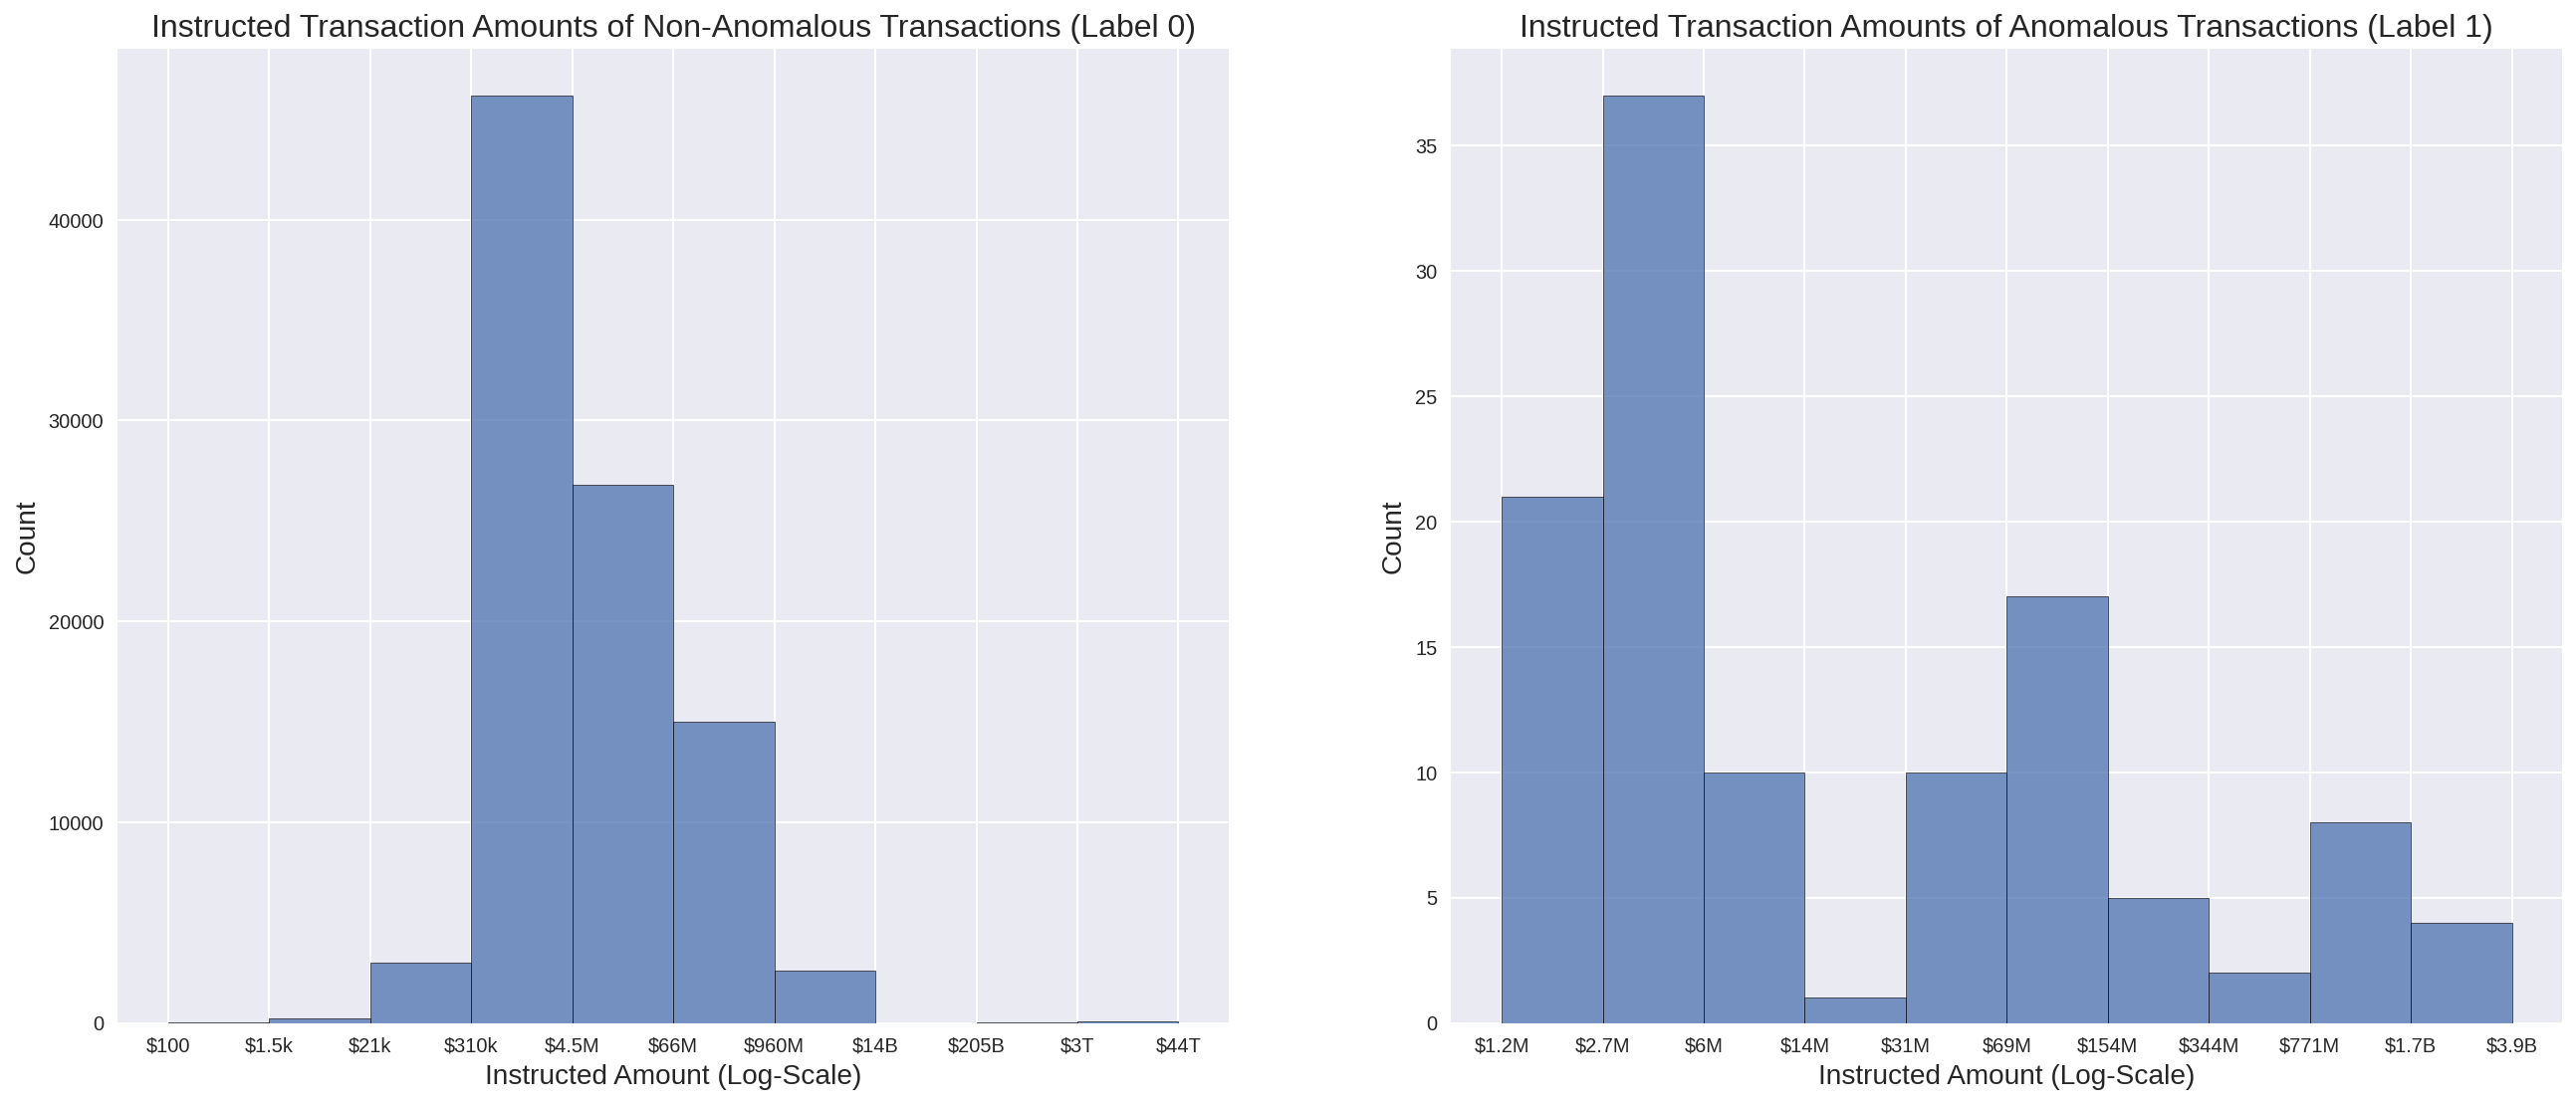

In [128]:
# Define figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 9))

# Plot histogram of non-anomalous transactions; log x-axis due to extreme right-skew
sns.histplot(x='InstructedAmount', data=viz_df[viz_df.Label == 0], ax=ax1, bins=10, log_scale=True)

# Plot histogram of anomalous transactions; log x-axis due to extreme right-skew
sns.histplot(x='InstructedAmount', data=viz_df[viz_df.Label == 1], ax=ax2, bins=10, log_scale=True)

ax1.set_title('Instructed Transaction Amounts of Non-Anomalous Transactions (Label 0)', fontsize=16)
ax1.set_xlabel('Instructed Amount (Log-Scale)', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax2.set_title('Instructed Transaction Amounts of Anomalous Transactions (Label 1)', fontsize=16)
ax2.set_xlabel('Instructed Amount (Log-Scale)', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)

# Set xticks to match bin widths
ax1.set_xticks([bin.get_x() for bin in ax1.patches] + [viz_df[viz_df.Label == 0]['InstructedAmount'].max()])
ax2.set_xticks([bin.get_x() for bin in ax2.patches] + [viz_df[viz_df.Label == 1]['InstructedAmount'].max()])
# Change xtick labels to more readable format
ax1.set_xticklabels(['$100', '$1.5k', '$21k', '$310k', '$4.5M', '$66M', '$960M', '$14B', '$205B', '$3T', '$44T'])
ax2.set_xticklabels(['$1.2M', '$2.7M', '$6M', '$14M', '$31M', '$69M', '$154M', '$344M', '$771M', '$1.7B', '$3.9B']);

**Remarks:**
- The distributions of instructed transaction amounts for both non-anomalous and anomalous transactions are both extremely right-skewed, which we can tell because the distributions look more or less normal after log-scaling.
- Non-anomalous transactions appear to have a much larger range of values, ranging from \$100 all the way into the tens of trillions of dollars (which is obviously unrealistic, but this is a synthetic dataset). The range for anomalous transactions is much more narrow, ranging from \$1.2M to just under $4B.

<br>

# Preprocessing & Feature Engineering

Steps:
1. Create `OriginalSender` and `FinalReceiver` features
2. Create `SenderFlag` and `ReceiverFlag` features by joining `banks_df`
3. Train/test split
4. Create `SenderHourFreq` feature
5. Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features
6. Create `SenderReceiverFreq` feature

### Create `OriginalSender` and `FinalReceiver` features

In [ ]:
# Create temporary tables to use with SQL
train_df.createOrReplaceTempView('train_df_sql')

# Create new features using SQL
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MIN(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MAX(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
)
SELECT train_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
LatestTransaction.Receiver AS FinalReceiver
FROM train_df_sql
LEFT JOIN EarliestTransaction
    ON EarliestTransaction.UETR = train_df_sql.UETR
LEFT JOIN LatestTransaction
    ON LatestTransaction.UETR = train_df_sql.UETR
"""

train_df = spark.sql(join_sql)

In [ ]:
# Retrieve three UETR codes of transactions where transactor used intermediary banks
random_rows = np.random.choice(train_df.filter(train_df.Receiver != train_df.FinalReceiver).count(), size=3, replace=False)
UETRs = [train_df.filter(train_df.Receiver != train_df.FinalReceiver).collect()[row]['UETR'] for row in random_rows]

# Display transactions to ensure OriginalSender and FinalReceiver columns are accurate
cols_to_show = ['Timestamp', 'UETR', 'Sender', 'Receiver', 'OriginalSender', 'FinalReceiver']
train_df.filter(train_df.UETR == UETRs[0]).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == UETRs[1]).select(cols_to_show).show(truncate=False)
train_df.filter(train_df.UETR == UETRs[2]).select(cols_to_show).show(truncate=False)

Repeat for `test_df`

In [ ]:
# Create temporary tables to use with SQL
train_df.createOrReplaceTempView('test_df_sql')

# Create new features using SQL
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM test_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MIN(Timestamp) 
    FROM test_df_sql 
    GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM test_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MAX(Timestamp) 
    FROM test_df_sql 
    GROUP BY UETR)
)
SELECT test_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
LatestTransaction.Receiver AS FinalReceiver
FROM test_df_sql
LEFT JOIN EarliestTransaction
    ON EarliestTransaction.UETR = test_df_sql.UETR
LEFT JOIN LatestTransaction
    ON LatestTransaction.UETR = test_df_sql.UETR
"""

test_df = spark.sql(join_sql)

In [ ]:
# Drop old 'Sender' and 'Receiver' columns
train_df = train_df.drop('Sender', 'Receiver')
test_df = test_df.drop('Sender', 'Receiver')

### Create `SenderFlag` and `ReceiverFlag` features by joining `banks_df`

<br>

In [ ]:
# # Create temporary tables for join
train_df.sample(False, 0.1).createOrReplaceTempView('train_df_sql')
banks_df.createOrReplaceTempView('banks_df_sql')


# # SQL to join dataframes
# join_sql =  """
#     SELECT min(Timestamp) AS EarliestTransaction, 
#     max(Timestamp) AS LatestTransaction
#     FROM train_df_sql
#     Group by UETR
# """
join_sql =  """WITH OrderingAccounts AS (
    SELECT OrderingAccount
    FROM train_df_sql
), 
BeneficiaryAccounts AS (
    SELECT BeneficiaryAccount
    FROM train_df_sql
), 
AccountsOrdering AS (
    SELECT Account, Flags
    FROM banks_df_sql
), 
AccountsBeneficiary AS (
    SELECT Account, Flags
    FROM banks_df_sql
), 
TransactionTimes AS (
    SELECT min(Timestamp) AS EarliestTransaction, 
    max(Timestamp) AS LatestTransaction
    FROM train_df_sql
    Group by UETR
)
SELECT train_df_sql.*, 
AccountsOrdering.Account AS MatchingOrderingAccount, 
AccountsOrdering.Flags AS OrderingAccountFlag, 
AccountsBeneficiary.Account AS MatchingBeneficiaryAccount, 
AccountsBeneficiary.Flags AS BeneficiaryAccountFlag
FROM train_df_sql
LEFT JOIN (
    SELECT Account, max()
)

AccountsOrdering
    ON train_df_sql.OrderingAccount = AccountsOrdering.Account

LEFT JOIN AccountsBeneficiary
    ON train_df_sql.BeneficiaryAccount = AccountsBeneficiary.Account


#             """
# # Perform SQL join
joined_df = spark.sql(join_sql)

In [ ]:
join_sql =  """
WITH TransactionTimes AS (
    SELECT UETR, 
    min(Timestamp) AS EarliestTransaction, 
    max(Timestamp) AS LatestTransaction
    FROM train_df_sql
    Group by UETR
), 
OrderingAccounts AS (
    SELECT OrderingAccount
    FROM train_df_sql
), 
BeneficiaryAccounts AS (
    SELECT BeneficiaryAccount
    FROM train_df_sql
), 
AccountsOrdering AS (
    SELECT Account, Flags
    FROM banks_df_sql
), 
AccountsBeneficiary AS (
    SELECT Account, Flags
    FROM banks_df_sql
)
SELECT train_df_sql.*, 
AccountsOrdering.Account AS MatchingOrderingAccount, 
AccountsOrdering.Flags AS OrderingAccountFlag, 
AccountsBeneficiary.Account AS MatchingBeneficiaryAccount, 
AccountsBeneficiary.Flags AS BeneficiaryAccountFlag
FROM train_df_sql
LEFT JOIN AccountsOrdering
    ON train_df_sql.OrderingAccount = AccountsOrdering.Account
        WHERE train_df_sql

LEFT JOIN AccountsBeneficiary
    ON train_df_sql.BeneficiaryAccount = AccountsBeneficiary.Account


"""

In [ ]:
join_sql = """
SELECT UETR, 
min(Timestamp) AS EarliestTransaction, 
max(Timestamp) AS LatestTransaction
FROM train_df_sql
GROUP BY UETR
"""
joined_df1 = spark.sql(join_sql)

In [ ]:
# WITH EarliestTransaction AS (
join_sql = """

SELECT UETR, 
Sender, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
  (SELECT UETR, MIN(Timestamp) 
  FROM train_df_sql 
  GROUP BY UETR)

"""

joined_df2 = spark.sql(join_sql)

In [ ]:
# WITH LatestTransaction AS (
join_sql = """

SELECT UETR, 
Receiver, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
  (SELECT UETR, MAX(Timestamp) 
  FROM train_df_sql 
  GROUP BY UETR)

"""

joined_df3 = spark.sql(join_sql)

In [ ]:
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MIN(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
    (SELECT UETR, MAX(Timestamp) 
    FROM train_df_sql 
    GROUP BY UETR)
)
SELECT train_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
LatestTransaction.Receiver AS FinalReceiver
FROM train_df_sql
LEFT JOIN EarliestTransaction
    ON EarliestTransaction.UETR = train_df_sql.UETR
LEFT JOIN LatestTransaction
    ON LatestTransaction.UETR = train_df_sql.UETR
"""

joined_df_SR = spark.sql(join_sql)

In [ ]:
join_sql = """
WITH EarliestTransaction AS (
SELECT UETR, 
Sender, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
  (SELECT UETR, MIN(Timestamp) 
  FROM train_df_sql 
  GROUP BY UETR)
), 
LatestTransaction AS (
SELECT UETR, 
Receiver, 
Timestamp
FROM train_df_sql 
WHERE (UETR, Timestamp) IN
  (SELECT UETR, MAX(Timestamp) 
  FROM train_df_sql 
  GROUP BY UETR)
), 
AccountsOrdering AS (
    SELECT Account, Flags
    FROM banks_df_sql
), 
AccountsBeneficiary AS (
    SELECT Account, Flags
    FROM banks_df_sql
)
SELECT train_df_sql.*, 
EarliestTransaction.Sender AS OriginalSender, 
AccountsOrdering.Account AS MatchingOrderingAccount, 
LatestTransaction.Receiver AS FinalReceiver, 
AccountsBeneficiary.Account AS MatchingReceivingAccount
FROM train_df_sql
LEFT JOIN EarliestTransaction
    ON EarliestTransaction.UETR = train_df_sql.UETR
LEFT JOIN LatestTransaction
    ON LatestTransaction.UETR = train_df_sql.UETR
LEFT JOIN AccountsOrdering
    ON EarliestTransaction.OrderingAccount = AccountsOrdering.Account
LEFT JOIN AccountsBeneficiary
    ON LatestTransaction.BeneficiaryAccount = AccountsBeneficiary.Account
"""

joined_dfx = spark.sql(join_sql)

### Drop intermediary transactions (only keep one row per end-to-end transaction)

In [ ]:
# Print count of unique transactions (as identified by UETR codes)
print('train_df:')
train_df.select(F.countDistinct('UETR')).show()
print('test_df:')
test_df.select(F.countDistinct('UETR')).show()

In [ ]:
# Print total number of combined rows with duplicate UETR values (meaning sender routed transaction through one or more intermediary banks)
print('Total number of rows with intermediary transactions in train_df:')
train_df.select('UETR').groupBy('UETR')\
    .count()\
    .where(F.col('count') > 1)\
    .select(F.sum('count'))\
    .show()

In [ ]:
# Drop rows with duplicate UETR codes, keeping the first occurence (sorted by Timestamp)
train_df = train_df.orderBy('Timestamp').coalesce(1).dropDuplicates(subset = ['UETR'])
test_df = test_df.orderBy('Timestamp').coalesce(1).dropDuplicates(subset = ['UETR'])

# Ensure no duplicates
assert train_df.groupBy(train_df.UETR).count().where(F.col('count') > 1).count() == 0
assert test_df.groupBy(test_df.UETR).count().where(F.col('count') > 1).count() == 0

print(f"train_df: {train_df.count()} rows")
print(f"test_df: {test_df.count()} rows")

In [ ]:
# Show value counts for 'Label' column (classification target) in new train and test dataframes
class_counts_train = train_df.groupBy('Label').count().withColumn('percent', F.col('count')/train_df.count())
class_counts_test = test_df.groupBy('Label').count().withColumn('percent', F.col('count')/test_df.count())

print('train_df:')
class_counts_train.show(truncate=10)
print('test_df:')
class_counts_test.show(truncate=10)

### Create `SenderHourFreq` feature: transaction hour frequency for each sender

This feature will tell us the frequency with which each sender initiated transactions for each hour of the day. This should capture the signal of the correlation between the sender and target class as well as the correlation between transaction hour and target class.

In [ ]:
# Define UDF to extract hour from timestamp
hour = F.udf(lambda x: x.hour, IntegerType())

# Create new column of transaction hours
train_df = train_df.withColumn('Hour', hour(train_df.Timestamp))
test_df = test_df.withColumn('Hour', hour(test_df.Timestamp))

# Create list of unique senders
senders = train_df.select('Sender').toPandas()['Sender'].unique()

# Create column of senders concatenated with hours
train_df = train_df.withColumn('SenderHour', F.concat(F.col('Sender'), F.col('Hour').cast(StringType())))
test_df = test_df.withColumn('SenderHour', F.concat(F.col('Sender'), F.col('Hour').cast(StringType())))

pd_df = train_df.select('Sender', 'Hour').toPandas()

# Create dictionary of sender hour frequency values to map from sender hour values
sender_hour_frequency = {}
for sender in senders:
    sender_rows = pd_df[pd_df['Sender'] == sender]
    for hour in range(24):
        sender_hour_frequency[sender + str(hour)] = len(sender_rows[sender_rows['Hour'] == hour])

# Create new column in train and test dataframes with sender_hour_frequency dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_hour_frequency.items())])

train_df = train_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])
test_df = test_df.withColumn('SenderHourFreq', mapping_expr[F.col('SenderHour')])

### Create `SenderCurrencyFreq` and `SenderCurrencyAmtAvg` features: transaction currency frequency and average transaction amount per currency for each sender

These features will tell us the frequency with which each sender initiated transactions for each currency, in the case of the first feature. For the second feature, it will tell us the average amount with which each sender sent each currency. These features may also be correlated with anomalous transactions.

In [ ]:
# Create column of senders concatenated with instructed currencies
train_df = train_df.withColumn('SenderCurrency', F.concat(F.col('Sender'), F.col('InstructedCurrency')))
test_df = test_df.withColumn('SenderCurrency', F.concat(F.col('Sender'), F.col('InstructedCurrency')))

pd_train_df = train_df.select('SenderCurrency', 'InstructedAmount').toPandas()
pd_test_df = test_df.select('SenderCurrency', 'InstructedAmount').toPandas()

# Create dictionary of sender currency frequency values to map from sender currency values
sender_currency_freq = {}
# Create dictionary of average sender currency values to map from sender currency values
sender_currency_avg = {}

for sc in set(
    list(pd_train_df['SenderCurrency'].unique()) + list(pd_test_df['SenderCurrency'].unique())
):
    sender_currency_freq[sc] = len(pd_train_df[pd_train_df['SenderCurrency'] == sc])
    sender_currency_avg[sc] = pd_train_df[pd_train_df['SenderCurrency'] == sc][
        "InstructedAmount"
    ].mean()

# Create new column in train and test dataframes with sender_currency_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_freq.items())])

train_df = train_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyFreq', mapping_expr[F.col('SenderCurrency')])

# Create new column in train and test dataframes with sender_currency_avg dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_currency_avg.items())])

train_df = train_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])
test_df = test_df.withColumn('SenderCurrencyAmtAvg', mapping_expr[F.col('SenderCurrency')])

### Create `SenderReceiverFreq` feature: sender-receiver combination frequency for each sender and receiver

In [ ]:
# Create column of senders concatenated with receivers
train_df = train_df.withColumn('SenderReceiver', F.concat(F.col('Sender'), F.col('Receiver')))
test_df = test_df.withColumn('SenderReceiver', F.concat(F.col('Sender'), F.col('Receiver')))

# Create dictionary of sender receiver frequency values to map from sender receiver values
sender_receiver_freq = {}

pd_train_df = train_df.select('SenderReceiver').toPandas()
pd_test_df = test_df.select('SenderReceiver').toPandas()

for sr in set(
    list(pd_train_df['SenderReceiver'].unique()) + list(pd_test_df['SenderReceiver'].unique())
):
    sender_receiver_freq[sr] = len(pd_train_df[pd_train_df['SenderReceiver'] == sr])

# Create new column in train and test dataframes with sender_receiver_freq dictionary
mapping_expr = F.create_map([F.lit(x) for x in chain(*sender_receiver_freq.items())])

train_df = train_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])
test_df = test_df.withColumn('SenderReceiverFreq', mapping_expr[F.col('SenderReceiver')])

### Drop unused categorical columns

We're going to drop all categorical columns here, save for the ones which are one hot encoding which are  . We'll also drop `SettlementAmount`, since it is essentially equivalent to `InstructedAmount` less deductions for fees and transfer/forex charges.

In [ ]:
cols_to_drop = [
    'Timestamp',
    'UETR',
    'Sender',
    'Receiver',
    'TransactionReference',
    'OrderingAccount',
    'OrderingName',
    'OrderingStreet',
    'OrderingCountryCityZip',
    'BeneficiaryAccount',
    'BeneficiaryName',
    'BeneficiaryStreet',
    'BeneficiaryCountryCityZip',
    'SettlementDate',
    'SettlementCurrency',
    'SettlementAmount'
    'SenderHour',
    'SenderCurrency',
    'SenderReceiver'
]

train_df = train_df.drop(*cols_to_drop)
test_df = test_df.drop(*cols_to_drop)

<br>

# Resample Training Dataset

As we saw above, the training dataset is extremely imbalanced in regards to target class distribution. In order to improve modeling performance, we'll rebalance the dataset through a combination of undersampling the majority class (non-amomalous transactions) and oversampling the minority class (anomalous transactions). Using the function I wrote in helper_functions.py, we'll specify an even positive to negative class balance in the new resampled dataframe, with 500,000 observations (so approximately 250k of each).

In [ ]:
print(spark_resample.__doc__)

In [ ]:
# Resample train_df; specify 500,000 observations in new resampled dataframe, with 
# balanced (0.5) ratio of positive target class (1) to negative target class (0)
train_df_resampled = spark_resample(train_df, ratio=0.5, new_count=500000, 
                                    class_field='Label', pos_class=1, shuffle=True, random_state=42)

In [ ]:
# Print shape of resampled dataframe
print(f"train_df_resampled:  {train_df_resampled.count()} Rows, {len(train_df_resampled.columns)} Columns")

In [ ]:
# Preview resampled dataframe
train_df_resampled.show(3, vertical=True)

In [ ]:
# Display value counts for 'Label' column (classification target) of resampled dataframe
resampled_class_counts = train_df_resampled.groupBy('Label')\
                                           .count()\
                                           .withColumn('percent', F.col('count')/train_df_resampled.count())

resampled_class_counts.show(truncate=10)

### Save resampled training dataframe and preprocessed test dataframe as CSV files

In [ ]:
# train_df_resampled.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/train_df_resampled.csv', header=True)
# test_df.coalesce(1).write.csv('/content/drive/MyDrive/Colab Notebooks/test_df_preprocessed.csv', header=True)